# Regularization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from torchvision import datasets, transforms

In [3]:
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor(),])
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([transforms.ToTensor(),])
)

In [4]:
x = train.data.float() / 255.
y = train.targets

x.shape

torch.Size([60000, 28, 28])

In [5]:
x = x.view(x.size(0), -1) # |x| = (x.size(0), 28 *28)
print(x.shape, y.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [6]:
input_size = x.size(-1) # 28*28
output_size = int(max(y)) + 1 # 10
print(f"input_size: {input_size}, output_size: {output_size}")

input_size: 784, output_size: 10


In [7]:
# Train / Valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = x.size(0) - train_cnt
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]
print(f"Train {train_cnt} / Valid {valid_cnt} / Test {test_cnt}")

Train 48000 / Valid 12000 / Test 10000


In [8]:
indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)] # min/max scaling
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


# Build Regularized Model & Optimizer

In [9]:
# nn.Module을 상속받은 다른 class에도 똑같이 접근 가능

class Block(nn.Module):
    def __init__(self,
                 input_size,
                 output_size, 
                 use_batch_norm=True,
                 dropout_p = .4):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p
        
        super().__init__() # nn.Module의 __init__ method 호출
        
        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)
        
        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size),
        )
        
    def forward(self, x):
        # |x| = (batch_size, input_size)
        y = self.block(x)
        
        return y

In [25]:
class MyModel(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size, 
                 use_batch_norm=True,
                 dropout_p=.4):
        
        super().__init__()
        
        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p),
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            nn.Linear(100, output_size),
            nn.LogSoftmax(dim=-1),
        )
        
    def forward(self, x):

        y = self.layers(x)
        return y
            

In [26]:
model = MyModel(input_size, output_size, use_batch_norm=True)
model

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [27]:
# loss function
crit = nn.NLLLoss()

In [28]:
optimizer = optim.Adam(model.parameters())

# Move to GPU if it is available

In [29]:
deviece = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Cuda is possible")

Cuda is possible


In [30]:
model = model.to(device)
x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

# Train

In [31]:
n_epochs = 1000
batch_size= 256
print_interval = 10

In [32]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [33]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train() # 학습과 추론을 반드시 구별하여 입력할 것.
    
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    
    # batch 학습
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss)
        
    train_loss = train_loss / len(x_)
    
    # 추론영역
    model.eval() # 반드시 작성해야 올바른 성능이 나온다.
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        # batch 추론 시작
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i)
            
            valid_loss += float(loss)
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i + 1) % print_interval == 0:
        print(f"Epoch {i+1}: train loss= {train_loss:.4f} / valid loss= {valid_loss:.4f} / lowest loss= {lowest_loss:.4f} ")
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f"There is no improvment during last {early_stop} epochs.")
            break
            
print(f"The best validation loss from epoch: {lowest_epoch+1}: {lowest_loss:.4f}")
model.load_state_dict(best_model)

Epoch 10: train loss= 0.0210 / valid loss= 0.0877 / lowest loss= 0.0785 
Epoch 20: train loss= 0.0141 / valid loss= 0.0805 / lowest loss= 0.0739 
Epoch 30: train loss= 0.0063 / valid loss= 0.0759 / lowest loss= 0.0739 
Epoch 40: train loss= 0.0061 / valid loss= 0.0816 / lowest loss= 0.0696 
Epoch 50: train loss= 0.0047 / valid loss= 0.0919 / lowest loss= 0.0696 
Epoch 60: train loss= 0.0015 / valid loss= 0.0782 / lowest loss= 0.0696 
Epoch 70: train loss= 0.0026 / valid loss= 0.0808 / lowest loss= 0.0696 
Epoch 80: train loss= 0.0042 / valid loss= 0.0974 / lowest loss= 0.0696 
There is no improvment during last 50 epochs.
The best validation loss from epoch: 38: 0.0696


<All keys matched successfully>

# Loss History

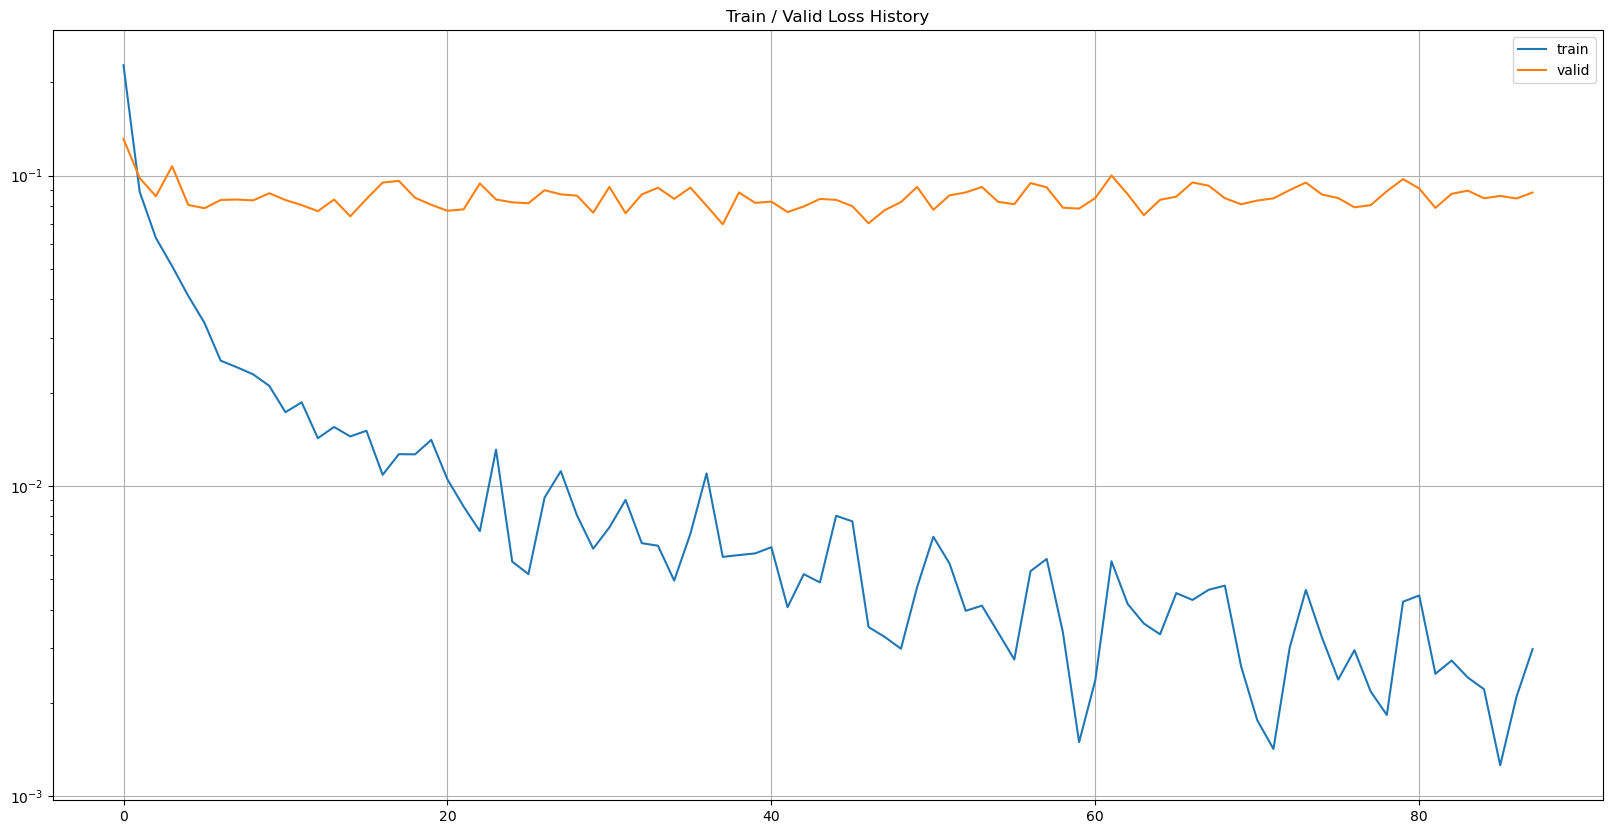

In [35]:

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")

plt.plot(range(len(train_history)), train_history, label='train')
plt.plot(range(len(valid_history)), valid_history, label='valid')

plt.yscale('log')
plt.legend()
plt.show()

# Let's see the result

In [44]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)
    
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i)
        
        test_loss += float(loss)
        y_hat += [y_hat_i] # 정답 검증을 위해 예측한 값을 저장
        
test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print(f"Test loss: {test_loss:.4f}")

Test loss: 0.0702


In [46]:
correct_cnt = (y[-1] == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print(f"Accuracy: {correct_cnt/total_cnt:.4f}")

Accuracy: 0.9832


In [47]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [49]:
true = y[-1].cpu().numpy()
pred = torch.argmax(y_hat, dim=-1).cpu().numpy()

pd.DataFrame(confusion_matrix(true, pred),
             index=[f'true_{i}' for i in range(10)],
             columns = [f'pred_{i}' for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,972,1,0,0,1,1,3,1,1,0
true_1,0,1130,0,0,0,0,2,1,2,0
true_2,2,3,1018,2,1,0,0,5,1,0
true_3,0,1,4,1000,0,0,0,3,1,1
true_4,1,0,1,1,957,0,5,3,0,14
true_5,2,0,0,11,0,871,3,2,1,2
true_6,2,2,2,1,1,5,944,0,1,0
true_7,1,5,8,0,0,0,0,1005,1,8
true_8,2,0,5,3,0,2,3,4,954,1
true_9,2,2,0,8,4,5,0,3,4,981
